# Assignment 5 – fine-tune a pretrained YOLO model on MNISTDD-RGB

In [ ]:
!pip -q install torch torchvision
!pip -q install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.6 MB/s eta 0:00:00


In [ ]:
import os
from tqdm import tqdm
from PIL import Image
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches
import numpy as np
import yaml
from ultralytics import YOLO

# Part A (In-Lab 2%)

## Loading the dataset

Google Drive dataset link for convenience: https://drive.google.com/drive/folders/1LclUCgK7JFVRU_oDQGQ-PH22YQTxc2kT

In [ ]:
local_path = '/content/drive'
remote_path = 'MyDrive/Colab Notebooks/'

from google.colab import drive
from pathlib import Path

drive.mount(local_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_zip = np.load(Path(local_path) / Path(remote_path) / 'train.npz')
train_images = torch.tensor(train_zip["images"]).reshape(-1, 64, 64, 3)  # [H, W, C] format
train_labels = torch.tensor(train_zip["labels"])
train_bboxes = torch.tensor(train_zip["bboxes"])

val_zip = np.load(Path(local_path) / Path(remote_path) / 'valid.npz')
val_images = torch.tensor(val_zip["images"]).reshape(-1, 64, 64, 3)  # [H, W, C] format
val_labels = torch.tensor(val_zip["labels"])
val_bboxes = torch.tensor(val_zip["bboxes"])

print(f"Number of images for:\n\tTraining:\t{train_images.shape[0]}\n\tValidation:\t{val_images.shape[0]}")

Number of images for:
	Training:	55000
	Validation:	5000


In [ ]:
print(train_images[0].shape, train_labels[0].shape, train_bboxes[0].shape, sep="\n")

torch.Size([64, 64, 3])
torch.Size([2])
torch.Size([2, 4])


### Image and bbox visualization

In [ ]:
# TODO: display some image from the dataset (to understand what is the format and shapes)

import matplotlib.patches as patches # Import patches

def show_image_and_bboxes(image, bboxes=None, labels=None):
  """
  Display an image with bounding boxes and labels.

  Args:
      image: tensor of shape (3, H, W) or (H, W, 3) or (H*W*C,)
      bboxes: tensor of shape (N, 4) with format [x_min, y_min, x_max, y_max]
      labels: tensor of shape (N,) with class labels
  """
  fig, ax = plt.subplots(1, figsize=(8, 8))

  # Normalize to [0, 1] if needed
  if image.max() > 1.0:
      image = image / 255.0

  ax.imshow(image)

  # Draw bounding boxes
  if bboxes is not None:
      if torch.is_tensor(bboxes):
          bboxes = bboxes.numpy()
      if torch.is_tensor(labels):
          labels = labels.numpy()

      # Filter out padding (all zeros)
      valid_boxes = ~np.all(bboxes == 0, axis=1)
      bboxes = bboxes[valid_boxes]
      if labels is not None:
          labels = labels[valid_boxes]

      for i, bbox in enumerate(bboxes):
          x_min, y_min, x_max, y_max = bbox
          width = x_max - x_min
          height = y_max - y_min

          # Create rectangle patch
          rect = patches.Rectangle(
              (x_min, y_min), width, height,
              linewidth=2, edgecolor='red', facecolor='none'
          )
          ax.add_patch(rect)

          # Add label text
          if labels is not None:
              label_text = f"Class {int(labels[i])}"
              ax.text(
                  x_min, y_min - 2, label_text,
                  color='red', fontsize=12,
                  bbox=dict(facecolor='white', alpha=0.7)
              )

  ax.axis('off')
  plt.tight_layout()
  plt.show()

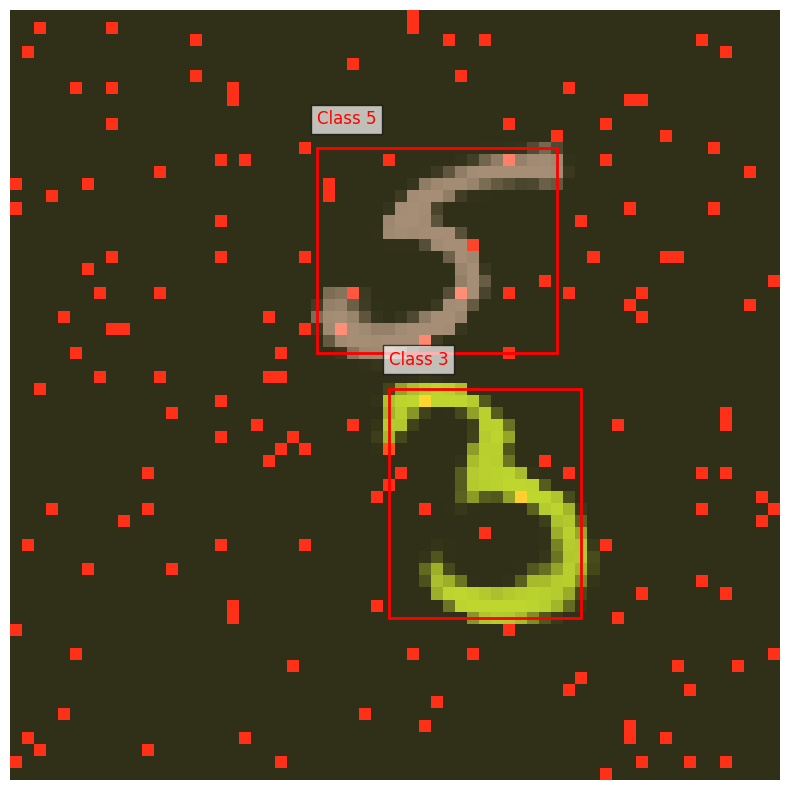

In [ ]:
some_image_idx = 0
some_image = train_images[some_image_idx]
some_bboxes = train_bboxes[some_image_idx]
some_labels = train_labels[some_image_idx]

show_image_and_bboxes(some_image, some_bboxes, some_labels)

### Prepare dataset for training

In [ ]:
def prepare_yolo_dataset(images, labels, bboxes, output_dir, split_name):
    """
    Convert dataset to YOLO format and save to disk.

    YOLO format:
    - Images: saved as .jpg files
    - Labels: .txt files with format: class_id x_center y_center width height
      (all normalized to [0, 1])
    """
    images_dir = Path(output_dir) / split_name / 'images'
    labels_dir = Path(output_dir) / split_name / 'labels'

    images_dir.mkdir(parents=True, exist_ok=True)
    labels_dir.mkdir(parents=True, exist_ok=True)

    print(f"Preparing {split_name} set...")

    for idx in tqdm(range(len(images))):
        img = images[idx].numpy()
        bbox = bboxes[idx].numpy()
        label = labels[idx].numpy()

        # Convert to uint8 if needed
        if img.dtype != np.uint8:
            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)

        # Save image
        img_path = images_dir / f"{idx:05d}.jpg"
        Image.fromarray(img).save(img_path)

        # Convert bboxes to YOLO format
        label_path = labels_dir / f"{idx:05d}.txt"

        with open(label_path, 'w') as f:
            img_h, img_w = 64, 64  # MNISTDD-RGB is 64x64

            for box, cls in zip(bbox, label):
                x_min, y_min, x_max, y_max = box

                # Convert to YOLO format: x_center, y_center, width, height (normalized)
                x_center = ((x_min + x_max) / 2) / img_w
                y_center = ((y_min + y_max) / 2) / img_h
                width = (x_max - x_min) / img_w
                height = (y_max - y_min) / img_h

                # Write: class_id x_center y_center width height
                f.write(f"{int(cls)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    print(f"Saved {len(images)} images and labels to {output_dir}/{split_name}")

# Create YOLO dataset structure
# For Part A: Use subset (~10K images) as per rubric
# For Part B: Use full dataset

# PART A: Using 10K training images (subset)
subset_size = 10000
train_images_subset = train_images[:subset_size]
train_labels_subset = train_labels[:subset_size]
train_bboxes_subset = train_bboxes[:subset_size]

print(f"\n{'='*80}")
print(f"PART A: Using SUBSET of training data")
print(f"  Training images: {len(train_images_subset)} (subset)")
print(f"  Validation images: {len(val_images)} (full)")
print(f"{'='*80}\n")

dataset_dir = '/content/mnistdd_yolo'
prepare_yolo_dataset(train_images_subset, train_labels_subset, train_bboxes_subset, dataset_dir, 'train')
prepare_yolo_dataset(val_images, val_labels, val_bboxes, dataset_dir, 'val')

# Verify files were created
train_img_dir = Path(dataset_dir) / 'train' / 'images'
train_lbl_dir = Path(dataset_dir) / 'train' / 'labels'
val_img_dir = Path(dataset_dir) / 'val' / 'images'
val_lbl_dir = Path(dataset_dir) / 'val' / 'labels'

print(f"\nDataset preparation complete!")
print(f"Train images: {len(list(train_img_dir.glob('*.jpg')))} files")
print(f"Train labels: {len(list(train_lbl_dir.glob('*.txt')))} files")
print(f"Val images: {len(list(val_img_dir.glob('*.jpg')))} files")
print(f"Val labels: {len(list(val_lbl_dir.glob('*.txt')))} files")

# Create YAML configuration file for YOLO
yaml_content = {
    'path': dataset_dir,
    'train': 'train/images',
    'val': 'val/images',
    'nc': 10,  # number of classes (digits 0-9)
    'names': [str(i) for i in range(10)]  # class names
}

yaml_path_partA = Path(dataset_dir) / 'dataPartA.yaml'
with open(yaml_path_partA, 'w') as f:
    yaml.dump(yaml_content, f)

print(f"\nDataset configuration saved to {yaml_path_partA}")


PART A: Using SUBSET of training data
  Training images: 10000 (subset)
  Validation images: 5000 (full)

Preparing train set...


100%|██████████| 10000/10000 [00:04<00:00, 2145.57it/s]


Saved 10000 images and labels to /content/mnistdd_yolo/train
Preparing val set...


100%|██████████| 5000/5000 [00:02<00:00, 1909.66it/s]


Saved 5000 images and labels to /content/mnistdd_yolo/val

Dataset preparation complete!
Train images: 55000 files
Train labels: 55000 files
Val images: 5000 files
Val labels: 5000 files

Dataset configuration saved to /content/mnistdd_yolo/dataPartA.yaml


### Training the Model

In [ ]:
# Load a pretrained YOLOv8 nano model (lightweight and fast)
model = YOLO('yolov8n.pt')

print("\nStarting training...")
# Train the model
results = model.train(
    data=str(yaml_path_partA),
    epochs=10,
    imgsz=64,
    batch=32,
    device='0' if torch.cuda.is_available() else 'cpu',
    project='mnistdd_runs',
    name='yolo_train',
    exist_ok=True,
    patience=10,
    save=True,
    plots=True
)

print("\nTraining completed!")


Starting training...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/mnistdd_yolo/dataPartA.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=64, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspe

In [ ]:
# Define paths
best_model_path = 'mnistdd_runs/yolo_train/weights/best.pt'
save_path = '/content/drive/MyDrive/yolo_mnistdd_best.pt'

# Copy using os.system (works fine in Colab)
if os.path.exists(best_model_path):
    os.system(f'cp "{best_model_path}" "{save_path}"')
    print(f"Model weights saved to {save_path}")

    # Check model size
    model_size_mb = os.path.getsize(best_model_path) / (1024 * 1024)
    print(f"Model size: {model_size_mb:.2f} MB")
else:
    print("Best model not found!")

### Compute IoU for the validation set

In [ ]:
best_model_path = 'mnistdd_runs/yolo_train/weights/best.pt'

def calculate_iou(box1, box2):
    """
    Calculate IoU between two bounding boxes.

    Args:
        box1, box2: arrays of shape (4,) with format [x_min, y_min, x_max, y_max]

    Returns:
        IoU value between 0 and 1
    """
    # Convert to float to avoid overflow
    box1 = box1.astype(np.float64) if hasattr(box1, 'astype') else np.array(box1, dtype=np.float64)
    box2 = box2.astype(np.float64) if hasattr(box2, 'astype') else np.array(box2, dtype=np.float64)

    # Calculate intersection coordinates
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Calculate intersection area
    inter_width = max(0.0, x2_inter - x1_inter)
    inter_height = max(0.0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height

    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    # Calculate IoU
    if union_area <= 0:
        return 0.0

    iou = float(inter_area / union_area)

    # Ensure IoU is in valid range [0, 1]
    iou = np.clip(iou, 0.0, 1.0)

    return iou

def evaluate_model_iou(model, val_images, val_bboxes, val_labels, num_samples=None):
    """
    Evaluate model performance using IoU metric.
    This calculates the average of best IoU matches between predictions and ground truth.
    """
    if num_samples is None:
        num_samples = len(val_images)

    all_ious = []
    total_gt_boxes = 0
    total_matches = 0

    print(f"\nEvaluating on {num_samples} validation samples...")

    for idx in tqdm(range(min(num_samples, len(val_images)))):
        # Get ground truth
        gt_bboxes = val_bboxes[idx].numpy()
        gt_labels = val_labels[idx].numpy()

        # Prepare image for prediction
        img = val_images[idx].numpy()

        # Run prediction
        results = model(img, verbose=False)

        # Extract predictions
        pred_boxes = results[0].boxes.xyxy.cpu().numpy() if len(results[0].boxes) > 0 else np.array([])
        pred_classes = results[0].boxes.cls.cpu().numpy() if len(results[0].boxes) > 0 else np.array([])

        # For each ground truth box, find best matching prediction
        for gt_idx, (gt_box, gt_label) in enumerate(zip(gt_bboxes, gt_labels)):
            total_gt_boxes += 1
            best_iou = 0.0

            if len(pred_boxes) > 0:
                # Find predictions with matching class
                for pred_idx, (pred_box, pred_class) in enumerate(zip(pred_boxes, pred_classes)):
                    # Only consider predictions with matching class
                    if int(pred_class) == int(gt_label):
                        iou = calculate_iou(gt_box, pred_box)
                        if iou > best_iou:
                            best_iou = iou

            all_ious.append(best_iou)
            if best_iou > 0.5:  # Count as match if IoU > 0.5
                total_matches += 1

    avg_iou = np.mean(all_ious) if len(all_ious) > 0 else 0.0
    detection_rate = total_matches / total_gt_boxes if total_gt_boxes > 0 else 0.0

    print(f"\nEvaluation Results:")
    print(f"  Average IoU: {avg_iou:.4f}")


    return avg_iou, all_ious

# Load the best model
best_model = YOLO(best_model_path)

# Evaluate on validation set
avg_iou, all_ious = evaluate_model_iou(best_model, val_images, val_bboxes, val_labels)


In [ ]:
def show_predictions(model, image, gt_bboxes, gt_labels, title="Predictions"):
    """
    Display image with both ground truth and predicted bounding boxes.
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))

    # Prepare image
    img = image.numpy() if torch.is_tensor(image) else image
    if img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    ax.imshow(img)

    # Draw ground truth boxes (green)
    gt_bboxes = gt_bboxes.numpy() if torch.is_tensor(gt_bboxes) else gt_bboxes
    gt_labels = gt_labels.numpy() if torch.is_tensor(gt_labels) else gt_labels

    valid_gt = ~np.all(gt_bboxes == 0, axis=1)
    gt_bboxes = gt_bboxes[valid_gt]
    gt_labels = gt_labels[valid_gt]

    for bbox, label in zip(gt_bboxes, gt_labels):
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='green', facecolor='none', label='Ground Truth'
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min - 2, f"GT: {int(label)}",
                color='green', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    # Get predictions
    results = model(img, verbose=False)
    pred_boxes = results[0].boxes

    # Draw predicted boxes (red)
    if len(pred_boxes) > 0:
        for box in pred_boxes:
            x_min, y_min, x_max, y_max = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())

            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='red', facecolor='none', linestyle='--'
            )
            ax.add_patch(rect)
            ax.text(x_max, y_max + 2, f"Pred: {cls} ({conf:.2f})",
                    color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    ax.set_title(title)
    ax.axis('off')

    # Create legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='green', lw=2, label='Ground Truth'),
        Line2D([0], [0], color='red', lw=2, linestyle='--', label='Prediction')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

# Show predictions on a few validation images
print("\nVisualizing predictions on validation set:")
for idx in range(5):
    show_predictions(
        best_model,
        val_images[idx],
        val_bboxes[idx],
        val_labels[idx],
        title=f"Validation Image {idx} - Predictions vs Ground Truth"
    )

print("\n" + "="*80)
print(f"- Model trained for 10 epochs")
print(f"- Average IoU on validation set: {avg_iou:.4f}")
print("="*80)

# Part B (Take-Home 3%)

### Prepare dataset for training for Part B

In [ ]:
# Create YOLO dataset structure
dataset_dir = '/content/mnistdd_yolo'
prepare_yolo_dataset(train_images, train_labels, train_bboxes, dataset_dir, 'train')
prepare_yolo_dataset(val_images, val_labels, val_bboxes, dataset_dir, 'val')

# Verify files were created
train_img_dir = Path(dataset_dir) / 'train' / 'images'
train_lbl_dir = Path(dataset_dir) / 'train' / 'labels'
val_img_dir = Path(dataset_dir) / 'val' / 'images'
val_lbl_dir = Path(dataset_dir) / 'val' / 'labels'

print(f"\nDataset preparation complete!")
print(f"Train images: {len(list(train_img_dir.glob('*.jpg')))} files")
print(f"Train labels: {len(list(train_lbl_dir.glob('*.txt')))} files")
print(f"Val images: {len(list(val_img_dir.glob('*.jpg')))} files")
print(f"Val labels: {len(list(val_lbl_dir.glob('*.txt')))} files")

# Create YAML configuration file for YOLO
yaml_content = {
    'path': dataset_dir,
    'train': 'train/images',
    'val': 'val/images',
    'nc': 10,  # number of classes (digits 0-9)
    'names': [str(i) for i in range(10)]  # class names
}

yaml_path_partB = Path(dataset_dir) / 'dataPartB.yaml'
with open(yaml_path_partB, 'w') as f:
    yaml.dump(yaml_content, f)

print(f"\nDataset configuration saved to {yaml_path_partB}")

Preparing train set...


100%|██████████| 55000/55000 [00:23<00:00, 2378.83it/s]


Saved 55000 images and labels to /content/mnistdd_yolo/train
Preparing val set...


100%|██████████| 5000/5000 [00:02<00:00, 2192.31it/s]


Saved 5000 images and labels to /content/mnistdd_yolo/val

Dataset preparation complete!
Train images: 55000 files
Train labels: 55000 files
Val images: 5000 files
Val labels: 5000 files

Dataset configuration saved to /content/mnistdd_yolo/dataPartB.yaml


### Training the model

In [ ]:
# Load a pretrained YOLOv8 nano model (lightweight and fast)
model = YOLO('yolov8n.pt')

print("\nTraining on full dataset with optimized hyperparameters...")
print("Configuration:")
print("  - Model: YOLOv8 nano")
print("  - Image size: 64x64")
print("  - Epochs: 50 (with early stopping)")
print("  - Batch size: 64")
print("  - Learning rate: 0.01 (default)")

print("\nStarting training...")

# Train with more epochs and better hyperparameters
results = model.train(
    data=str(yaml_path_partB),
    epochs=50,
    imgsz=64,
    batch=64,
    device='0' if torch.cuda.is_available() else 'cpu',
    project='mnistdd_runs',
    name='yolo_full_train',
    exist_ok=True,
    patience=10,  # Early stopping
    save=True,
    plots=True,
    conf=0.25,  # Confidence threshold
    iou=0.45,   # NMS IoU threshold
    lr0=0.01,   # Initial learning rate
    lrf=0.01,   # Final learning rate
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3,
    warmup_momentum=0.8,
    box=7.5,    # Box loss gain
    cls=0.5,    # Classification loss gain
    val=True,
    verbose=True
)

print("\nTraining completed!")


Training on full dataset with optimized hyperparameters...
Configuration:
  - Model: YOLOv8 nano
  - Image size: 64x64
  - Epochs: 30 (with early stopping)
  - Batch size: 64
  - Learning rate: 0.01 (default)

Starting training...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=0.25, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/mnistdd_yolo/dataPartB.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=64, int8=False, iou=0.45, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=

In [ ]:
# Define paths
best_model_path = 'mnistdd_runs/yolo_full_train/weights/best.pt'
save_path = '/content/drive/MyDrive/yolo_mnistdd_final_best.pt'

if os.path.exists(best_model_path):
    os.system(f'cp "{best_model_path}" "{save_path}"')
    print(f"Model weights saved to {save_path}")

    # Check model size
    model_size_mb = os.path.getsize(best_model_path) / (1024 * 1024)
    print(f"Model size: {model_size_mb:.2f} MB")

else:
    print("Best model not found!")

Model weights saved to /content/drive/MyDrive/yolo_mnistdd_final_best.pt
Model size: 5.91 MB


### Evaluation Metrics


1. Running YOLO validation (mAP, precision, recall)...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 104.2±49.5 MB/s, size: 1.4 KB)
val: Scanning /content/mnistdd_yolo/val/labels.cache... 5000 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5000/5000 8.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 157/157 8.4it/s 18.7s
                   all       5000      10000      0.972      0.943      0.982      0.799
                     0        946        996       0.97      0.977      0.993      0.857
                     1        928        985      0.967      0.732      0.891      0.606
                     2        943        989      0.984      0.981      0.994      0.821
                     3        953       1010      0.973      0.961      0.991

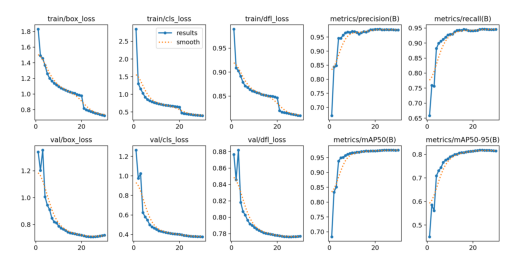


Evaluating on 5000 validation samples...


100%|██████████| 5000/5000 [00:37<00:00, 133.84it/s]

  Average IoU: 0.8538


In [ ]:
def calculate_iou(box1, box2):
    """
    Calculate IoU between two bounding boxes.

    Args:
        box1, box2: arrays of shape (4,) with format [x_min, y_min, x_max, y_max]

    Returns:
        IoU value between 0 and 1
    """
    # Convert to float to avoid overflow
    box1 = box1.astype(np.float64) if hasattr(box1, 'astype') else np.array(box1, dtype=np.float64)
    box2 = box2.astype(np.float64) if hasattr(box2, 'astype') else np.array(box2, dtype=np.float64)

    # Calculate intersection coordinates
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Calculate intersection area
    inter_width = max(0.0, x2_inter - x1_inter)
    inter_height = max(0.0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height

    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    # Calculate IoU
    if union_area <= 0:
        return 0.0

    iou = float(inter_area / union_area)

    # Ensure IoU is in valid range [0, 1]
    iou = np.clip(iou, 0.0, 1.0)

    return iou

def evaluate_model_iou(model, val_images, val_bboxes, val_labels, num_samples=None):
    """
    Evaluate model performance using IoU metric.
    This calculates the average of best IoU matches between predictions and ground truth.
    """
    if num_samples is None:
        num_samples = len(val_images)

    all_ious = []
    total_gt_boxes = 0
    total_matches = 0

    print(f"\nEvaluating on {num_samples} validation samples...")

    for idx in tqdm(range(min(num_samples, len(val_images)))):
        # Get ground truth
        gt_bboxes = val_bboxes[idx].numpy()
        gt_labels = val_labels[idx].numpy()

        # Prepare image for prediction
        img = val_images[idx].numpy()

        # Run prediction
        results = model(img, verbose=False)

        # Extract predictions
        pred_boxes = results[0].boxes.xyxy.cpu().numpy() if len(results[0].boxes) > 0 else np.array([])
        pred_classes = results[0].boxes.cls.cpu().numpy() if len(results[0].boxes) > 0 else np.array([])

        # For each ground truth box, find best matching prediction
        for gt_idx, (gt_box, gt_label) in enumerate(zip(gt_bboxes, gt_labels)):
            total_gt_boxes += 1
            best_iou = 0.0

            if len(pred_boxes) > 0:
                # Find predictions with matching class
                for pred_idx, (pred_box, pred_class) in enumerate(zip(pred_boxes, pred_classes)):
                    # Only consider predictions with matching class
                    if int(pred_class) == int(gt_label):
                        iou = calculate_iou(gt_box, pred_box)
                        if iou > best_iou:
                            best_iou = iou

            all_ious.append(best_iou)
            if best_iou > 0.5:  # Count as match if IoU > 0.5
                total_matches += 1

    avg_iou = np.mean(all_ious) if len(all_ious) > 0 else 0.0
    detection_rate = total_matches / total_gt_boxes if total_gt_boxes > 0 else 0.0

    print(f"\n  Average IoU: {avg_iou:.4f}")

    return avg_iou, all_ious

best_model_path = 'mnistdd_runs/yolo_full_train/weights/best.pt'

best_model = YOLO(best_model_path)

# Use YOLO's built-in validation for comprehensive metrics
print("\n1. Running YOLO validation (mAP, precision, recall)...")
val_results = best_model.val(data=str(yaml_path), imgsz=64, batch=32)

map50 = val_results.box.map50
map = val_results.box.map
precision = val_results.box.mp
recall = val_results.box.mr

print("\n" + "="*80)
print(f"\n- Model trained for 50 epochs")
print("\nEvaluation:")
print(f"   mAP@0.5: {map50:.4f}")
print(f"   mAP@0.5:0.95: {map:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall: {recall:.4f}")

# Evaluate on validation set
avg_iou, all_ious = evaluate_model_iou(best_model, val_images, val_bboxes, val_labels)

print("\n" + "="*80)

# Path to the plot you want to view
img_path = 'mnistdd_runs/yolo_full_train/results.png'

img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


Visualizing predictions on validation set:


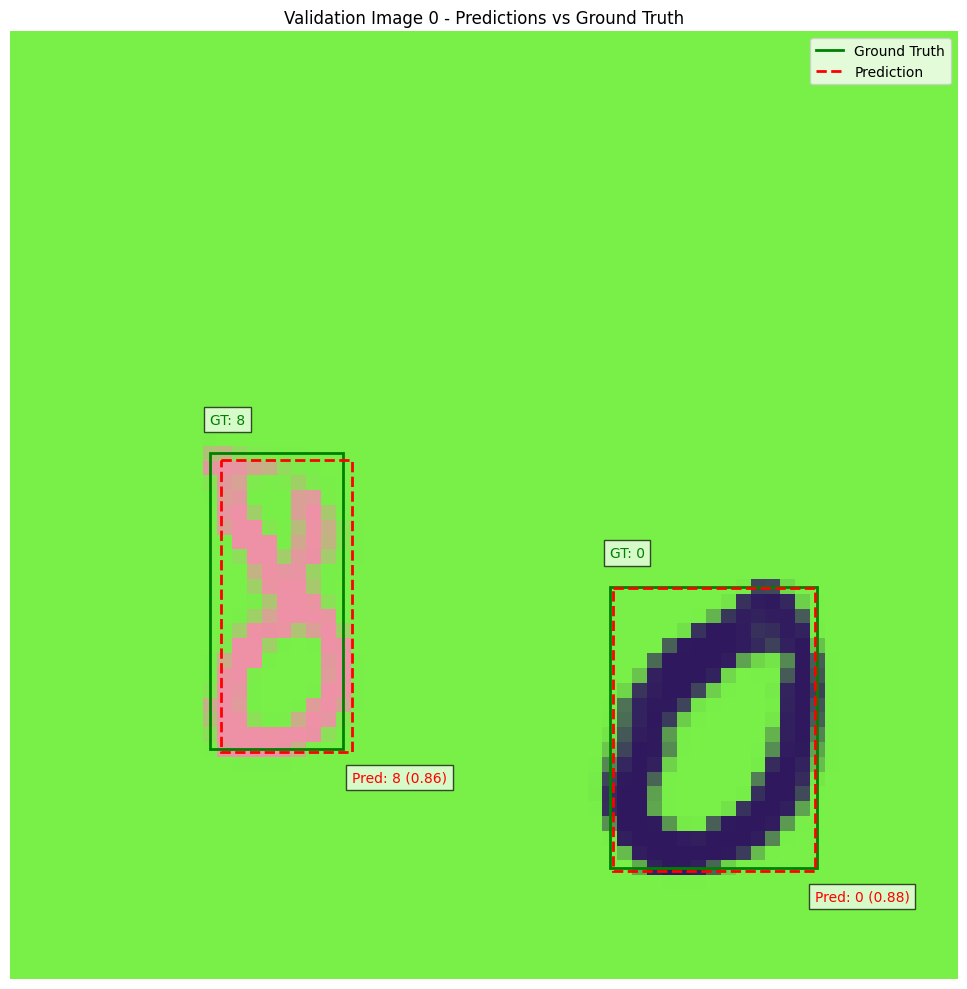

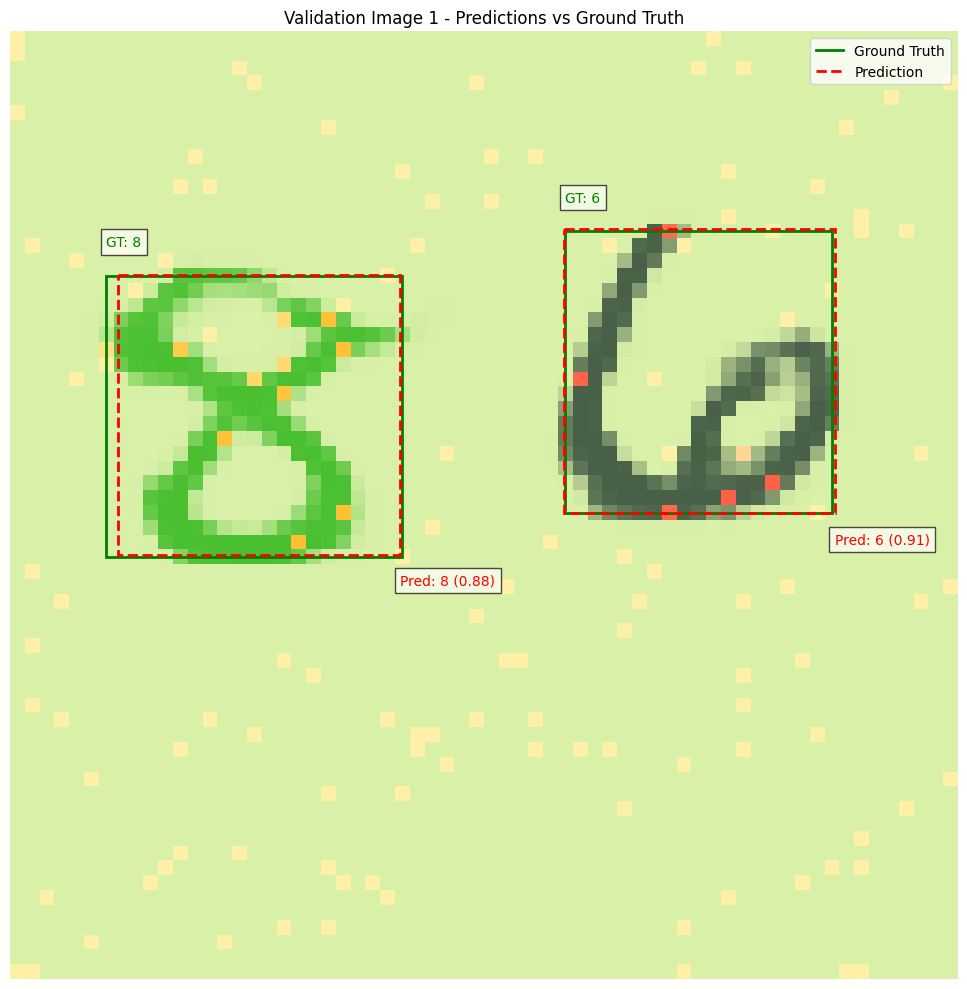

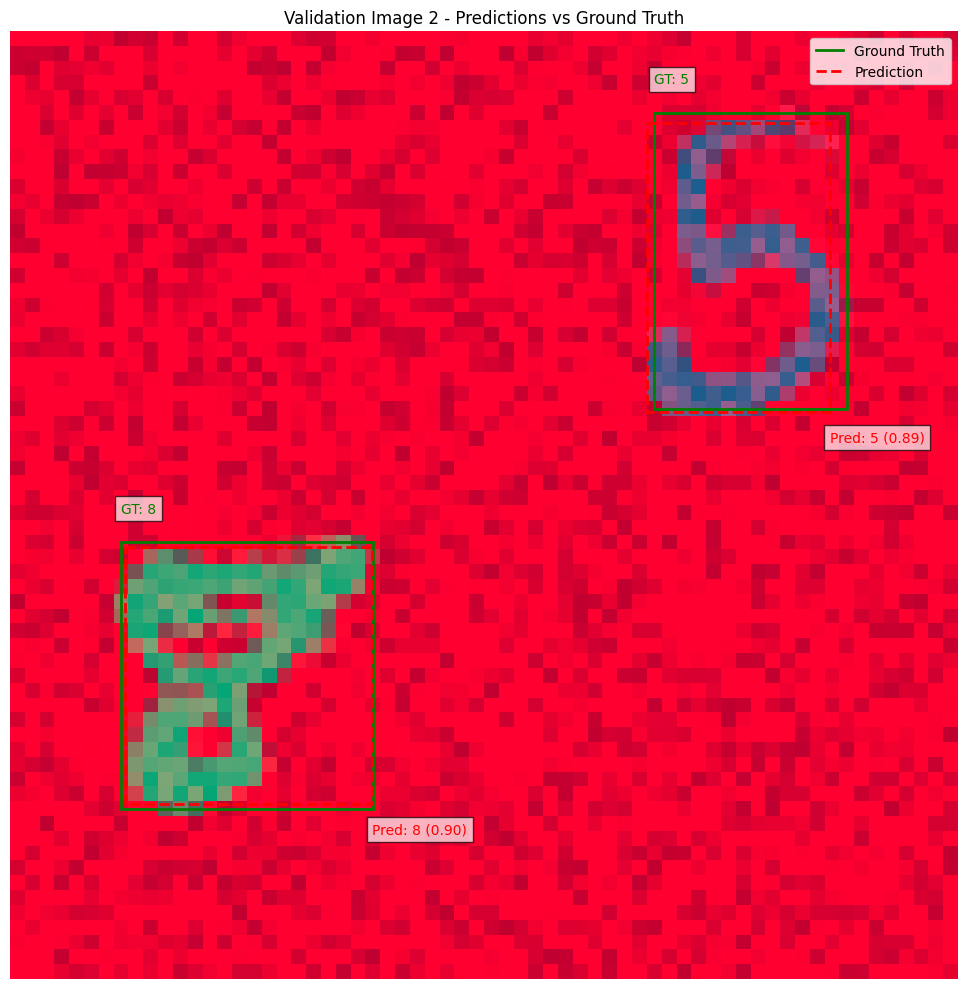

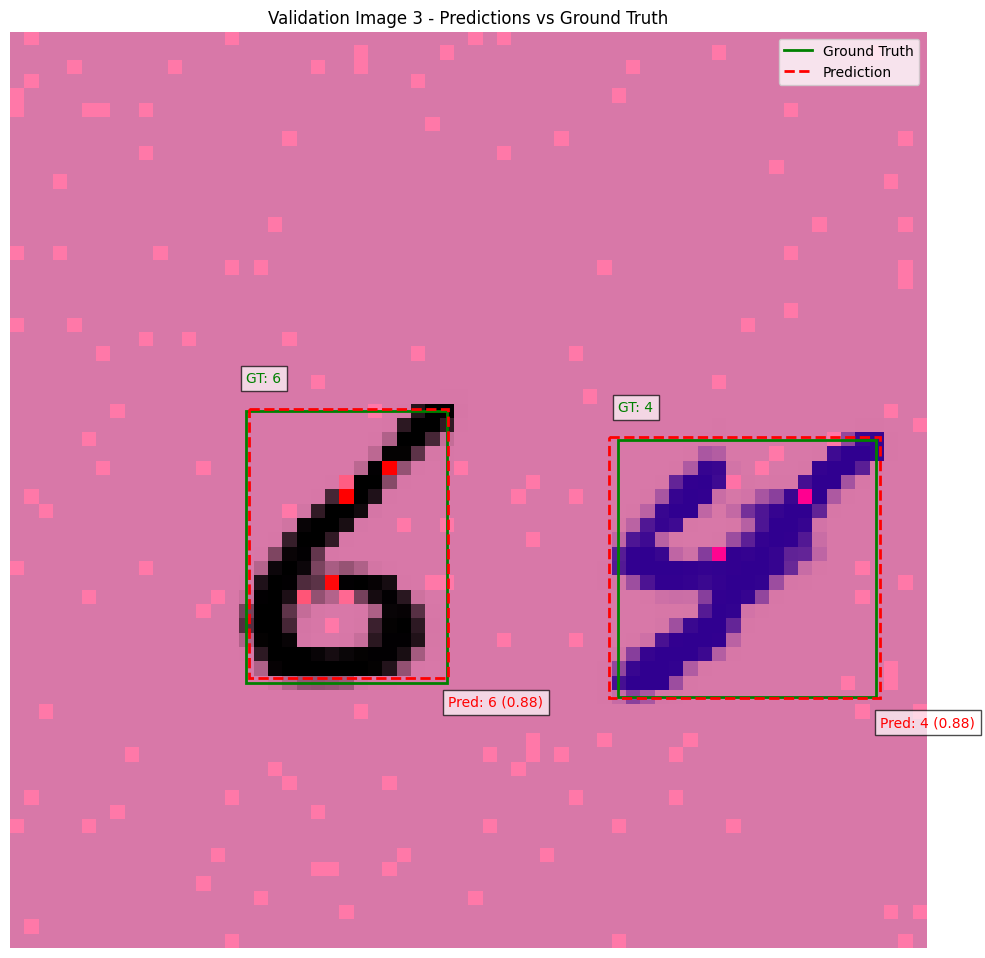

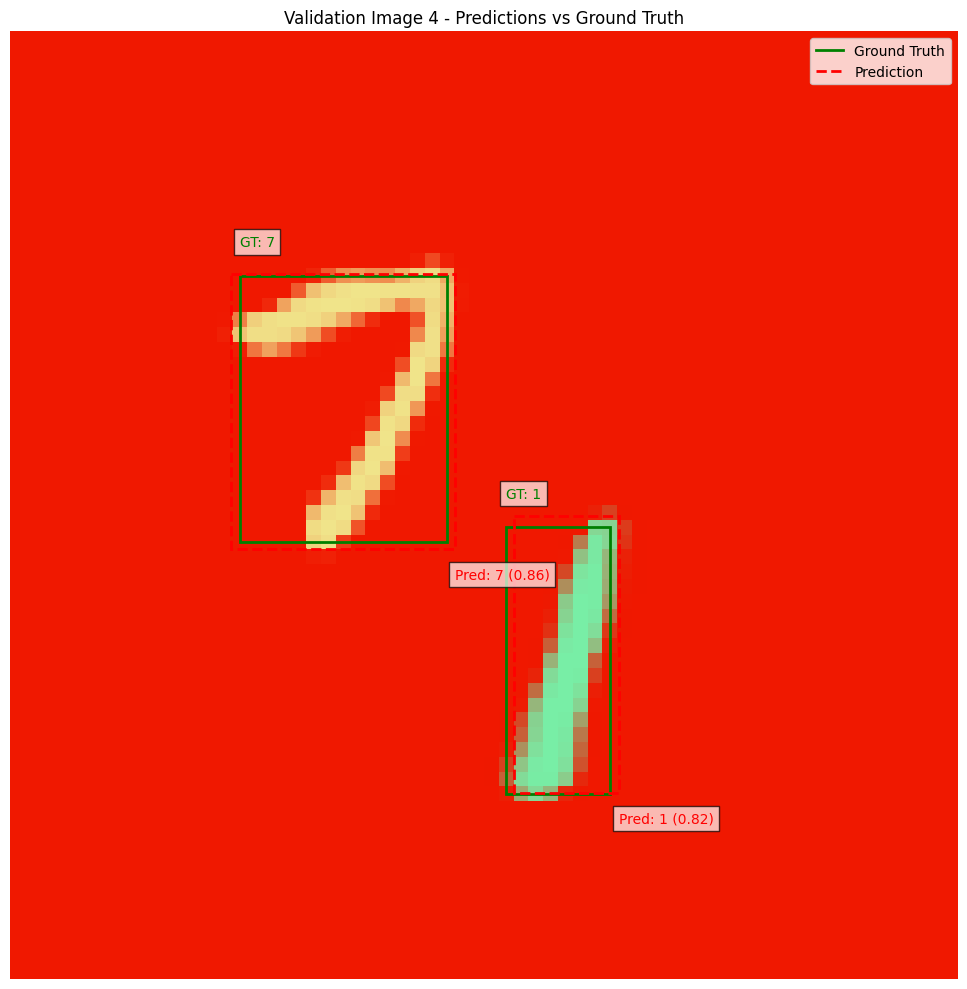

In [ ]:
def show_predictions(model, image, gt_bboxes, gt_labels, title="Predictions"):
    """
    Display image with both ground truth and predicted bounding boxes.
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))

    # Prepare image
    img = image.numpy() if torch.is_tensor(image) else image
    if img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    ax.imshow(img)

    # Draw ground truth boxes (green)
    gt_bboxes = gt_bboxes.numpy() if torch.is_tensor(gt_bboxes) else gt_bboxes
    gt_labels = gt_labels.numpy() if torch.is_tensor(gt_labels) else gt_labels

    valid_gt = ~np.all(gt_bboxes == 0, axis=1)
    gt_bboxes = gt_bboxes[valid_gt]
    gt_labels = gt_labels[valid_gt]

    for bbox, label in zip(gt_bboxes, gt_labels):
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='green', facecolor='none', label='Ground Truth'
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min - 2, f"GT: {int(label)}",
                color='green', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    # Get predictions
    results = model(img, verbose=False)
    pred_boxes = results[0].boxes

    # Draw predicted boxes (red)
    if len(pred_boxes) > 0:
        for box in pred_boxes:
            x_min, y_min, x_max, y_max = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())

            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='red', facecolor='none', linestyle='--'
            )
            ax.add_patch(rect)
            ax.text(x_max, y_max + 2, f"Pred: {cls} ({conf:.2f})",
                    color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    ax.set_title(title)
    ax.axis('off')

    # Create legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='green', lw=2, label='Ground Truth'),
        Line2D([0], [0], color='red', lw=2, linestyle='--', label='Prediction')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

# Show predictions on a few validation images
print("\nVisualizing predictions on validation set:")
for idx in range(5):
    show_predictions(
        best_model,
        val_images[idx],
        val_bboxes[idx],
        val_labels[idx],
        title=f"Validation Image {idx} - Predictions vs Ground Truth"
    )

The model weights you upload will be run by us (the TAs) on the held-out test set (which will be released _after_ the deadline).